<a href="https://colab.research.google.com/github/log-ghj/nonlinear/blob/main/Advanced_Econometrics_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install pyGAM as sklearn does not include GAM
!pip install pyGAM
!pip install fsspec

     |████████████████████████████████| 1.8MB 2.7MB/s 
     |████████████████████████████████| 92kB 2.2MB/s 


In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
import pygam
from pygam import LinearGAM, s, l, f
import statsmodels.api as sm
import statsmodels.formula.api as smf
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)
from statsmodels.iolib.summary2 import summary_col

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load the datafile from github
df = pd.read_csv('https://raw.githubusercontent.com/log-ghj/nonlinear/main/datafile.csv')
data = df.copy()
# Set panel data structure
data = data.set_index(['country_pair_cat', 'year'])

# Split the data set for sklearn syntax
X = data[['l_ln_origin_gdp_pc', 'l_ln_host_gdp_pc', 'l_ln_origin_pop',
          'l_ln_host_pop', 'log_dist', 'l_origin_social_protect_gdp', 
          'l_host_social_protect_gdp']]
y = data['ln_fdi_instock']

In [ ]:
# Set seed
np.random.seed(1)

# Run multiple GAM specifications and compare them to OLS
# Set the 10-fold CV
nobs = len(data)
fold = 10
ntest = int(np.round(nobs/fold))

# Set the GAM specifications
GAM_spec = [s(0)+l(1)+l(2)+l(3)+l(4)+l(5)+l(6), l(0)+s(1)+l(2)+l(3)+l(4)+l(5)+l(6),
            l(0)+l(1)+s(2)+l(3)+l(4)+l(5)+l(6), l(0)+l(1)+l(2)+s(3)+l(4)+l(5)+l(6),
            l(0)+l(1)+l(2)+l(3)+s(4)+l(5)+l(6), l(0)+l(1)+l(2)+l(3)+l(4)+s(5)+l(6),
            l(0)+l(1)+l(2)+l(3)+l(4)+l(5)+s(6)]
MSE = np.empty((fold,len(GAM_spec)+1))

for i in range(fold):
  # Split the data into training and testing parts
  if i<fold:
    test = data.iloc[i*ntest:(i+1)*ntest]
    df1 = data.iloc[0:i*ntest]
    df2 = data.iloc[(i+1)*ntest:]
    frames = [df1, df2]
    train = pd.concat(frames)
  else: 
    test = data.iloc[i*ntest:nobs]
    train = data.iloc[~i*ntest:nobs]
  
  X_test = test[['l_ln_origin_gdp_pc', 'l_ln_host_gdp_pc', 'l_ln_origin_pop',
                 'l_ln_host_pop', 'log_dist', 'l_origin_social_protect_gdp', 
                 'l_host_social_protect_gdp']]
  y_test = test['ln_fdi_instock']
  X_train = train[['l_ln_origin_gdp_pc', 'l_ln_host_gdp_pc', 'l_ln_origin_pop',
                 'l_ln_host_pop', 'log_dist', 'l_origin_social_protect_gdp', 
                 'l_host_social_protect_gdp']]
  y_train = train['ln_fdi_instock']

  regr_ols = linear_model.LinearRegression()
  regr_ols.fit(X_train, y_train)
  ols_pred = regr_ols.predict(X_test)
  MSE[i,7] = mean_squared_error(y_test, ols_pred)
  for j, spec in enumerate(GAM_spec):
    regr_gam = LinearGAM(spec)
    regr_gam.fit(X_train, y_train)
    gam_pred = regr_gam.predict(X_test)
    MSE[i,j] = mean_squared_error(y_test, gam_pred)

In [ ]:
# Spline on first and third term reduce MSE in comparison to OLS
np.mean(MSE, axis=0)

array([3.03534178, 3.23329593, 2.99057616, 5.60173583, 3.21233931,
       3.16830718, 3.66988596, 3.22064722])

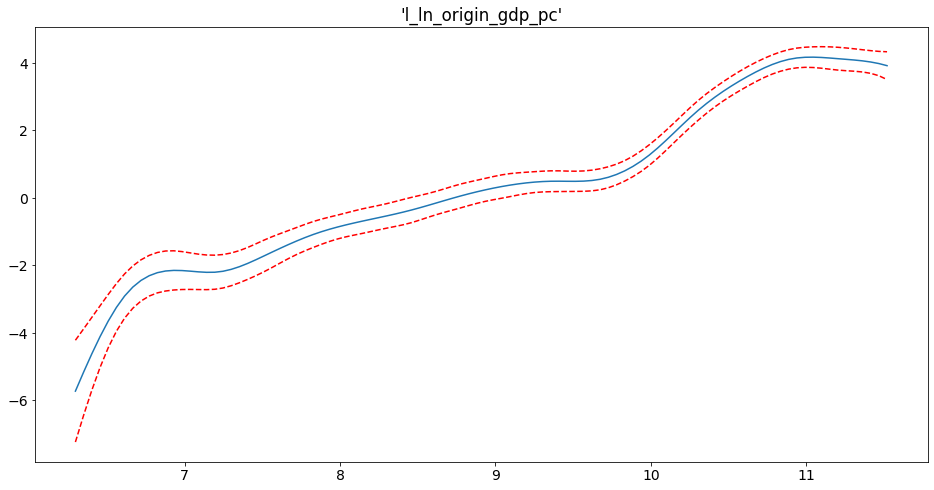

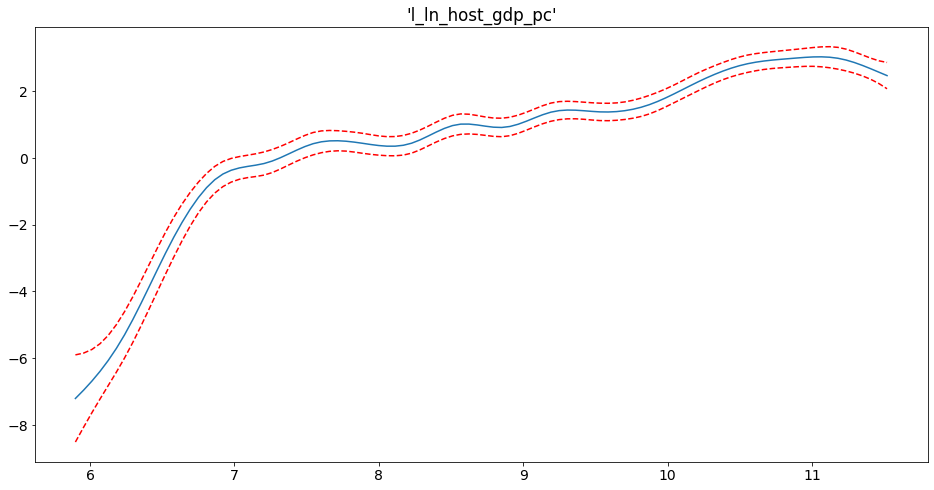

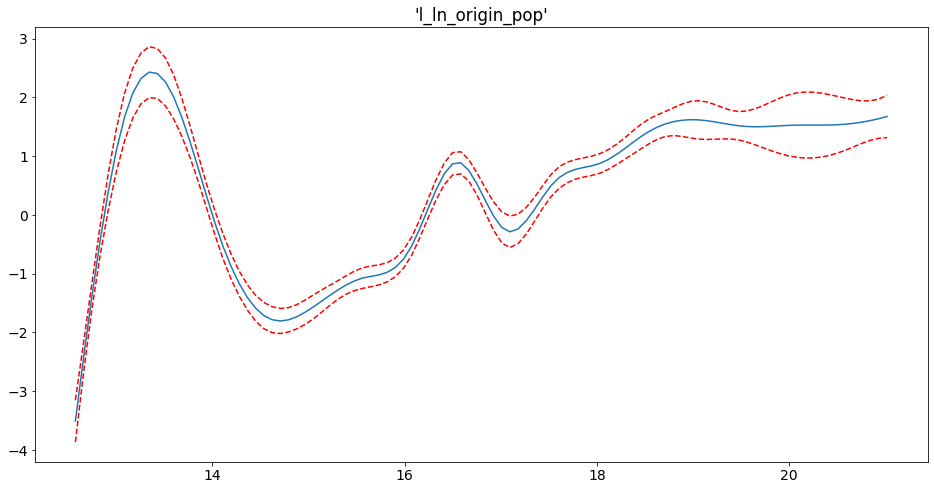

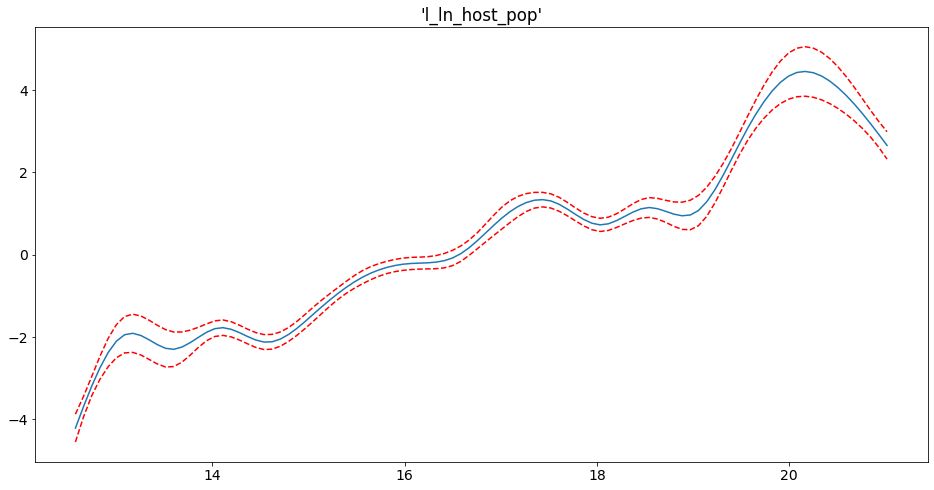

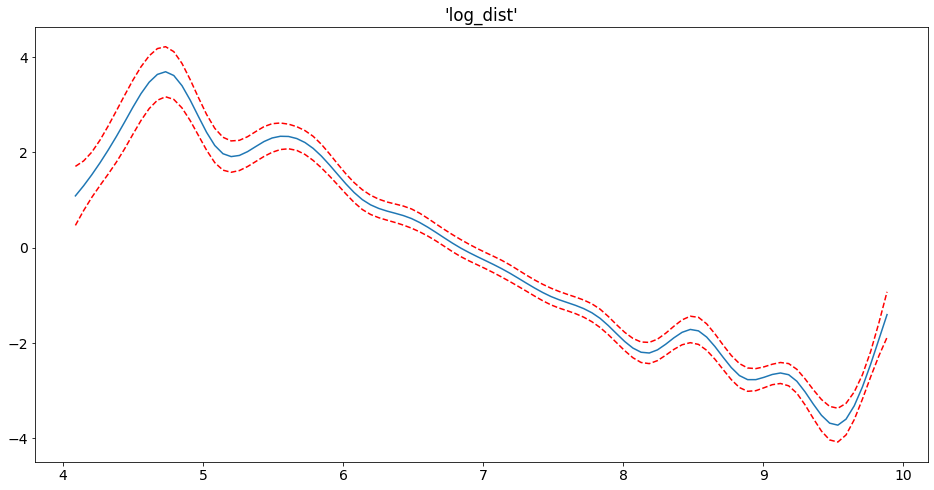

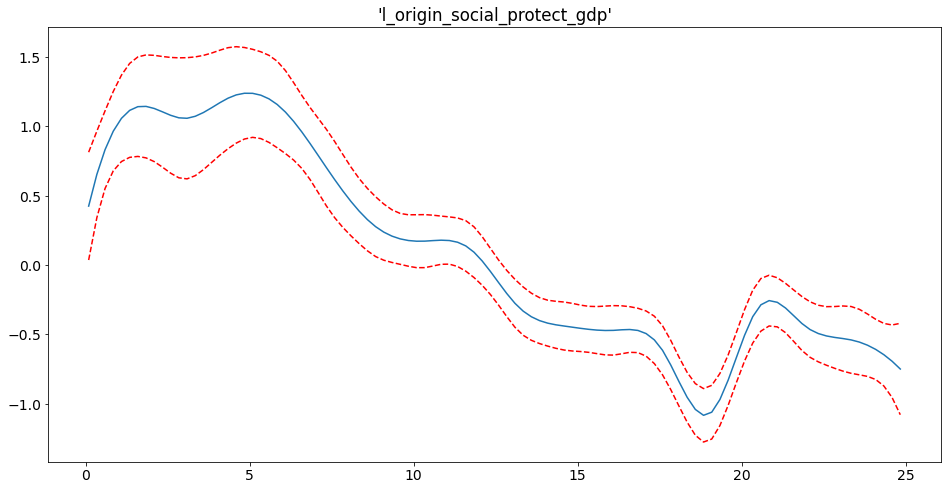

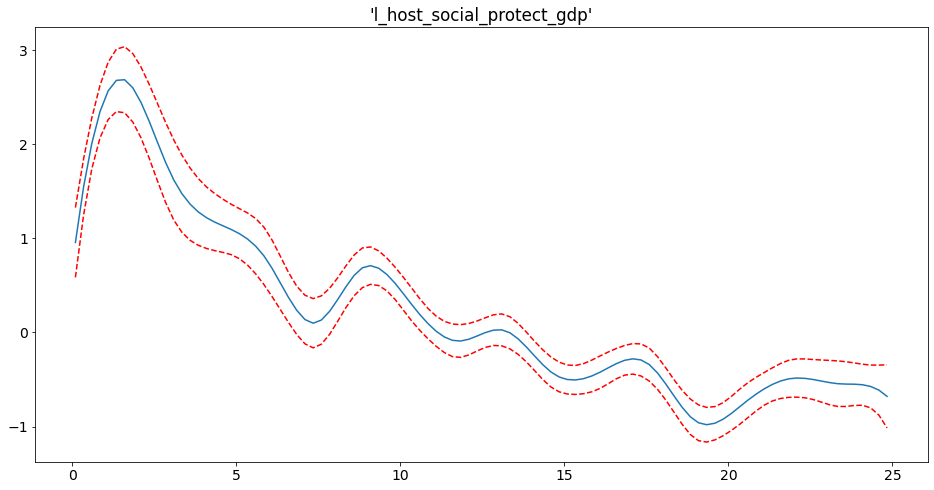

In [ ]:
# Plot the individual spline functions
names = ['l_ln_origin_gdp_pc', 'l_ln_host_gdp_pc', 'l_ln_origin_pop',
         'l_ln_host_pop', 'log_dist', 'l_origin_social_protect_gdp', 
         'l_host_social_protect_gdp']
regr_gam_lin = LinearGAM(s(0)+s(1)+s(2)+s(3)+s(4)+s(5)+s(6))
regr_gam_lin.fit(X, y)
for i, term in enumerate(regr_gam_lin.terms):
    if term.isintercept:
        continue

    XX = regr_gam_lin.generate_X_grid(term=i)
    pdep, confi = regr_gam_lin.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(names[i]))
    plt.show()
# Conclusion: Run GAM with spline on first and third x

In [ ]:
'''
This cell basically does the same as the R code in the slides tilted "Applications"
in the set of slides for the third part of the lecture - comparing OLS to 
non-linear methods. MSE are returned in next cell
'''
nlin_spec = [linear_model.LinearRegression(), LinearGAM(s(0)+l(1)+s(2)+l(3)+l(4)+l(5)+l(6)),
             RandomForestRegressor(), BaggingRegressor(), GradientBoostingRegressor()]
# Usinng OLS, the GAM for which we settled above, Random Forest, Bagging and Boosting
MSE_nlin = np.empty((fold, len(nlin_spec)))

for i in range(fold):
  # Split the data into training and testing parts
  if i<fold:
    test = data.iloc[i*ntest:(i+1)*ntest]
    df1 = data.iloc[0:i*ntest]
    df2 = data.iloc[(i+1)*ntest:]
    frames = [df1, df2]
    train = pd.concat(frames)
  else: 
    test = data.iloc[i*ntest:nobs]
    train = data.iloc[~i*ntest:nobs]
  
  X_test = test[['l_ln_origin_gdp_pc', 'l_ln_host_gdp_pc', 'l_ln_origin_pop',
                 'l_ln_host_pop', 'log_dist', 'l_origin_social_protect_gdp', 
                 'l_host_social_protect_gdp']]
  y_test = test['ln_fdi_instock']
  X_train = train[['l_ln_origin_gdp_pc', 'l_ln_host_gdp_pc', 'l_ln_origin_pop',
                 'l_ln_host_pop', 'log_dist', 'l_origin_social_protect_gdp', 
                 'l_host_social_protect_gdp']]
  y_train = train['ln_fdi_instock']

  for j, spec in enumerate(nlin_spec):
    spec.fit(X_train, y_train)
    spec_pred = spec.predict(X_test)
    MSE_nlin[i,j] = mean_squared_error(y_test, spec_pred)

In [ ]:
'''
Output of this cell implies that splines on 'l_ln_origin_gdp_pc', 
'l_ln_origin_pop', 'log_dist' in GAM leads to almost same result as 
fully-npnparametric -> left to do: add non-linear terms to OLS and get similar MSE
'''
np.mean(MSE_nlin, axis=0)

array([3.22064722, 2.8186537 , 2.76129716, 3.05293536, 2.84489319])

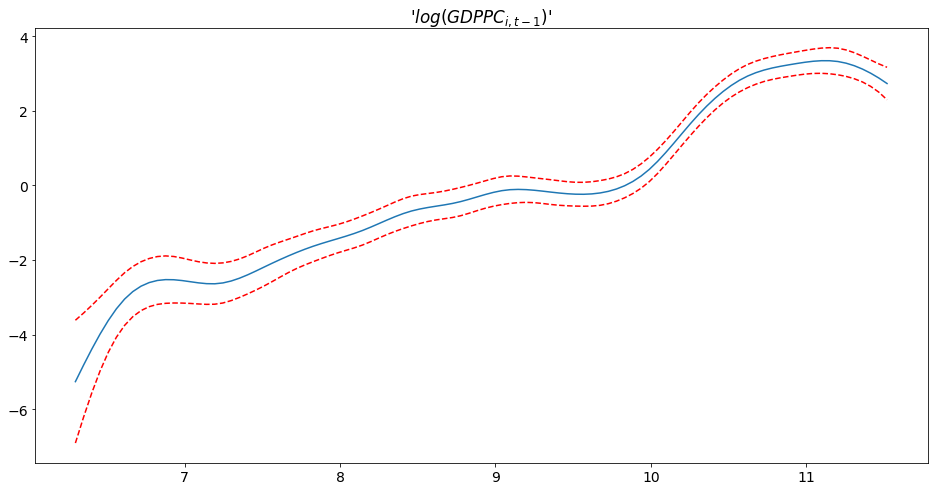

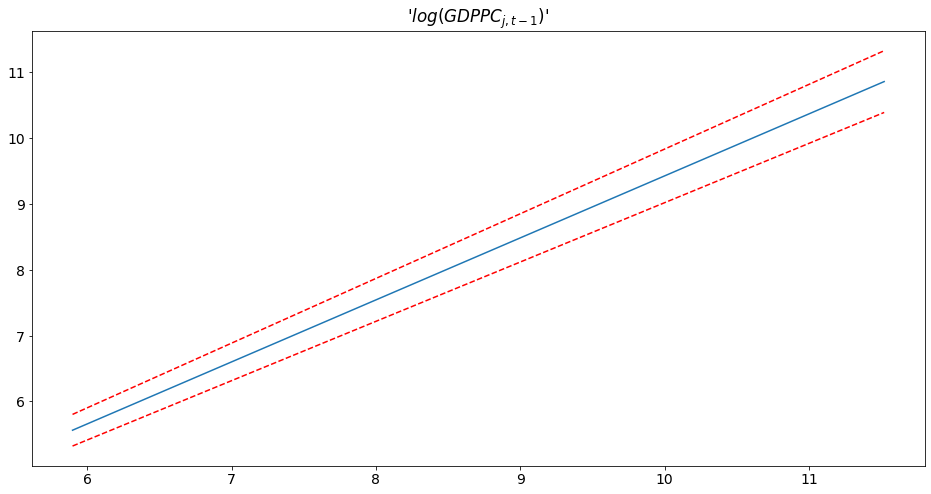

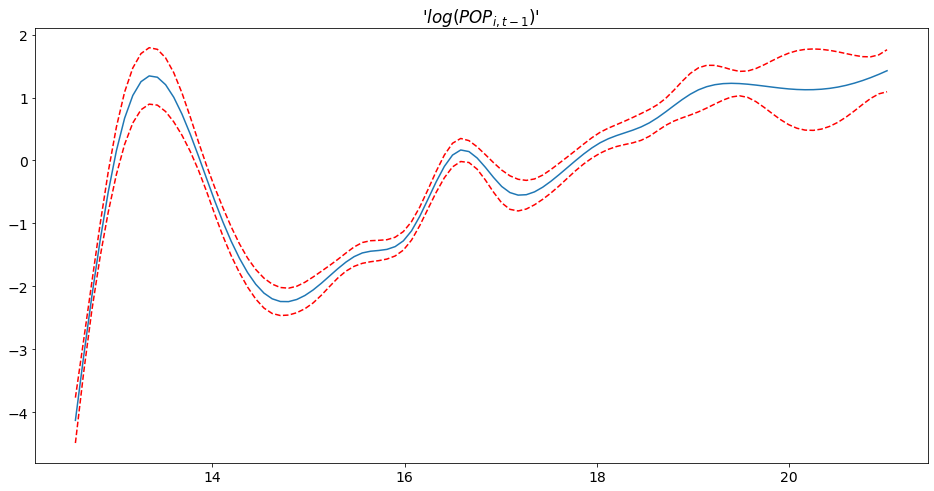

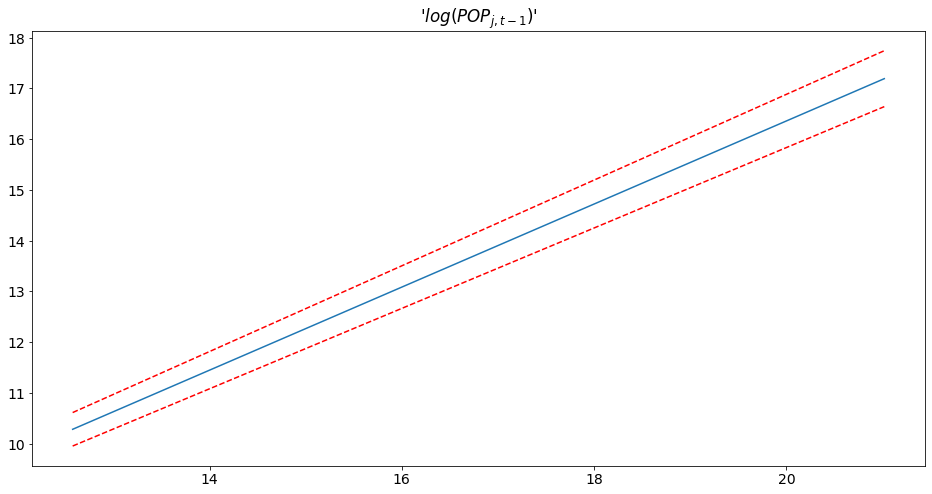

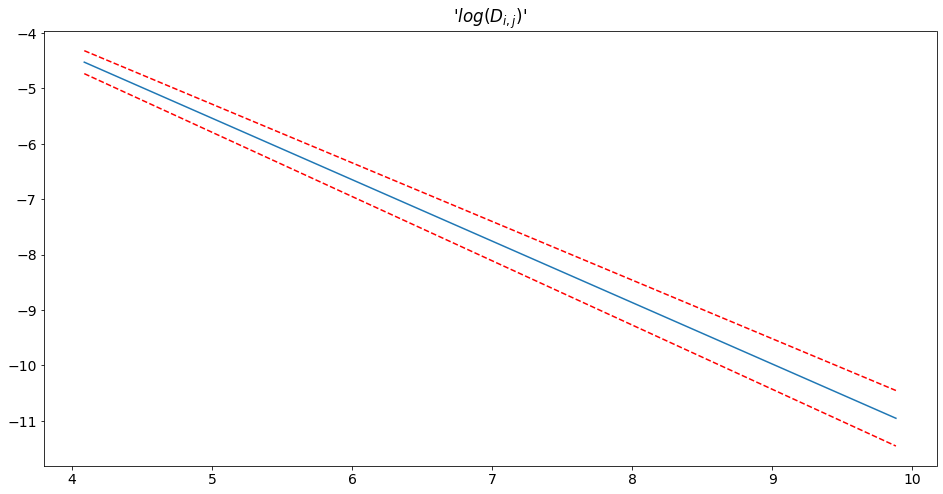

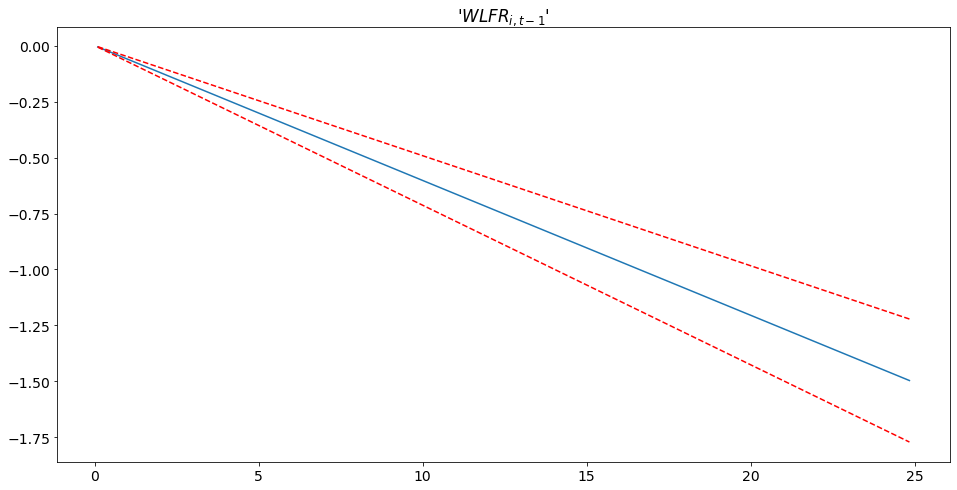

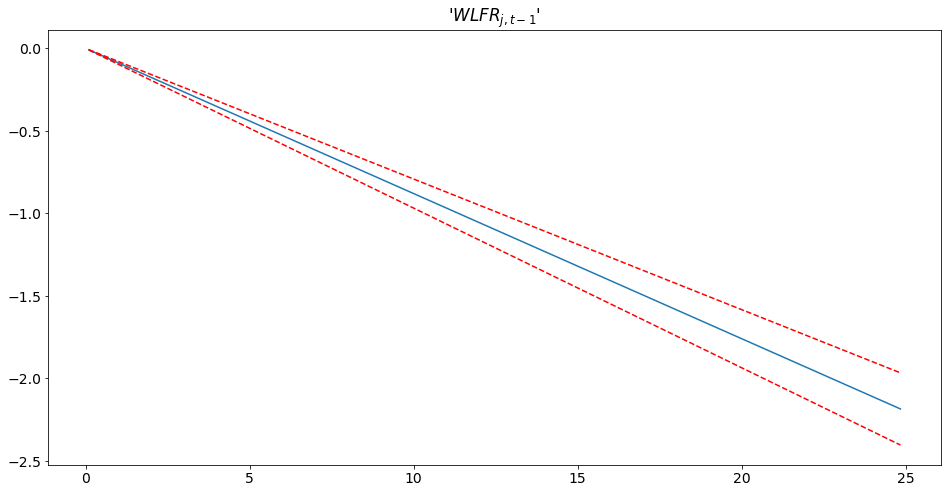

In [ ]:
# Let's plot the individual functions in gam to investigate form of non-linearities
names = ['$log(GDPPC_{i, t-1})$', '$log(GDPPC_{j, t-1})$', '$log(POP_{i, t-1})$',
         '$log(POP_{j, t-1})$', '$log(D_{i, j})$', '$WLFR_{i, t-1}$', 
         '$WLFR_{j, t-1}$']

for i, term in enumerate(regr_gam.terms):
    if term.isintercept:
        continue

    regr_gam = LinearGAM(s(0)+l(1)+s(2)+l(3)+l(4)+l(5)+l(6))
    regr_gam.fit(X, y)
    XX = regr_gam.generate_X_grid(term=i)
    pdep, confi = regr_gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(names[i]))
    plt.show()

In [ ]:
# Use statsmodels here instead of sklearn to run regressions with formulas like in R
# Beware differences in syntax of the packages
MSE_ols_nl = np.empty(fold)
for i in range(fold):
  # Split the data into training and testing parts
  if i<fold:
    test = data.iloc[i*ntest:(i+1)*ntest]
    df1 = data.iloc[0:i*ntest]
    df2 = data.iloc[(i+1)*ntest:]
    frames = [df1, df2]
    train = pd.concat(frames)
  else: 
    test = data.iloc[i*ntest:nobs]
    train = data.iloc[~i*ntest:nobs]
  
  X_test = test[['l_ln_origin_gdp_pc', 'l_ln_host_gdp_pc', 'l_ln_origin_pop',
                 'l_ln_host_pop', 'log_dist', 'l_origin_social_protect_gdp', 
                 'l_host_social_protect_gdp']]
  y_test = test['ln_fdi_instock']
  X_train = train[['l_ln_origin_gdp_pc', 'l_ln_host_gdp_pc', 'l_ln_origin_pop',
                 'l_ln_host_pop', 'log_dist', 'l_origin_social_protect_gdp', 
                 'l_host_social_protect_gdp']]
  y_train = train['ln_fdi_instock']

  data_sm_train = train[['ln_fdi_instock', 'l_ln_origin_gdp_pc', 'l_ln_host_gdp_pc',
                         'l_ln_origin_pop', 'l_ln_host_pop', 'log_dist',
                         'l_origin_social_protect_gdp', 'l_host_social_protect_gdp']]

  # Run OLS with nonlinearities based on graphs above
  formula = 'ln_fdi_instock ~ l_ln_origin_gdp_pc + l_ln_host_gdp_pc + l_ln_origin_pop + l_ln_host_pop + log_dist + l_origin_social_protect_gdp + l_host_social_protect_gdp + I((l_ln_origin_gdp_pc-7>0)*l_ln_origin_gdp_pc) + I((l_ln_origin_gdp_pc-9>0)*l_ln_origin_gdp_pc) + I((l_ln_origin_gdp_pc-10>0)*l_ln_origin_gdp_pc)  + I((l_ln_origin_gdp_pc-11>0)*l_ln_origin_gdp_pc) + I((l_ln_origin_pop-14.5>0)*l_ln_origin_pop) + I((l_ln_origin_pop-16.5>0)*l_ln_origin_pop)'
  regr_ols_mod = smf.ols(formula=formula, data=data_sm_train)
  regr_ols_res = regr_ols_mod.fit()
  ols_nl_pred = regr_ols_res.predict(X_test)
  MSE_ols_nl[i] = sm.tools.eval_measures.mse(y_test, ols_nl_pred)
np.mean(MSE_ols_nl)

2.9038268707316788

In [ ]:
# Compare OLS and augmented OLS
form_base = 'ln_fdi_instock ~ l_ln_origin_gdp_pc + l_ln_host_gdp_pc + l_ln_origin_pop + l_ln_host_pop + log_dist + l_origin_social_protect_gdp + l_host_social_protect_gdp'
regr_base = smf.ols(formula=form_base, data=data)
res_base = regr_base.fit()

form_aug = formula
regr_aug = smf.ols(formula=form_aug, data=data)
res_aug = regr_aug.fit()

In [ ]:
for x in [res_base, res_aug]:
  print(x.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_fdi_instock   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     1350.
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        09:10:44   Log-Likelihood:                -13550.
No. Observations:                6826   AIC:                         2.712e+04
Df Residuals:                    6818   BIC:                         2.717e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [ ]:
# Get the summary as latex for written report
for x in [res_base, res_aug]:
  print(x.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                  & ln\_fdi\_instock & \textbf{  R-squared:         } &     0.581   \\
\textbf{Model:}                          &       OLS        & \textbf{  Adj. R-squared:    } &     0.580   \\
\textbf{Method:}                         &  Least Squares   & \textbf{  F-statistic:       } &     1350.   \\
\textbf{Date:}                           & Wed, 04 Nov 2020 & \textbf{  Prob (F-statistic):} &     0.00    \\
\textbf{Time:}                           &     09:11:09     & \textbf{  Log-Likelihood:    } &   -13550.   \\
\textbf{No. Observations:}               &        6826      & \textbf{  AIC:               } & 2.712e+04   \\
\textbf{Df Residuals:}                   &        6818      & \textbf{  BIC:               } & 2.717e+04   \\
\textbf{Df Model:}                       &           7      & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                       

/usr/local/lib/python3.6/dist-packages/statsmodels/graphics/regressionplots.py:552: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


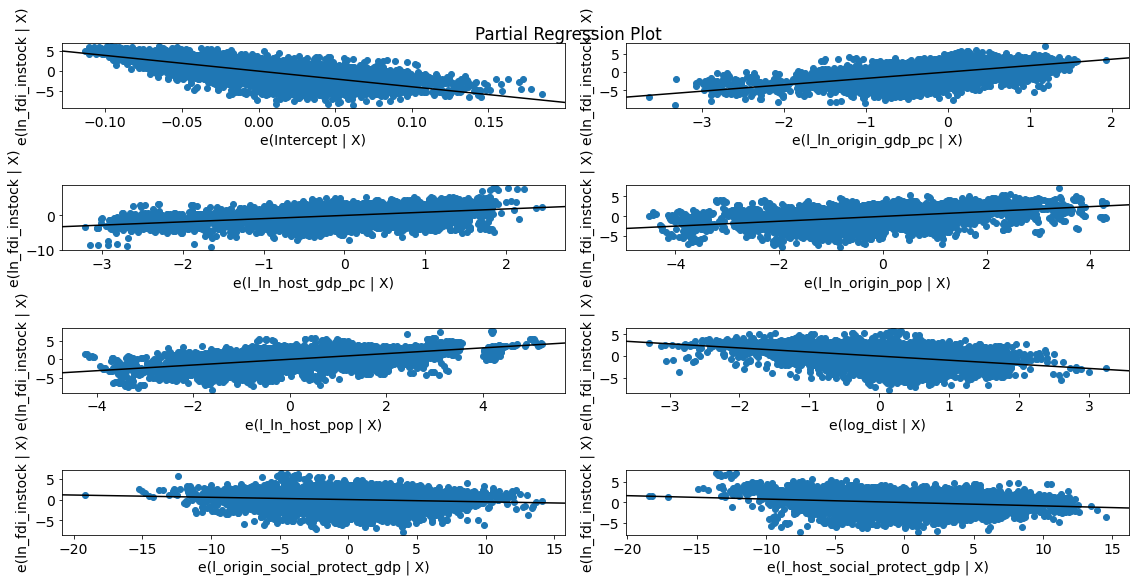

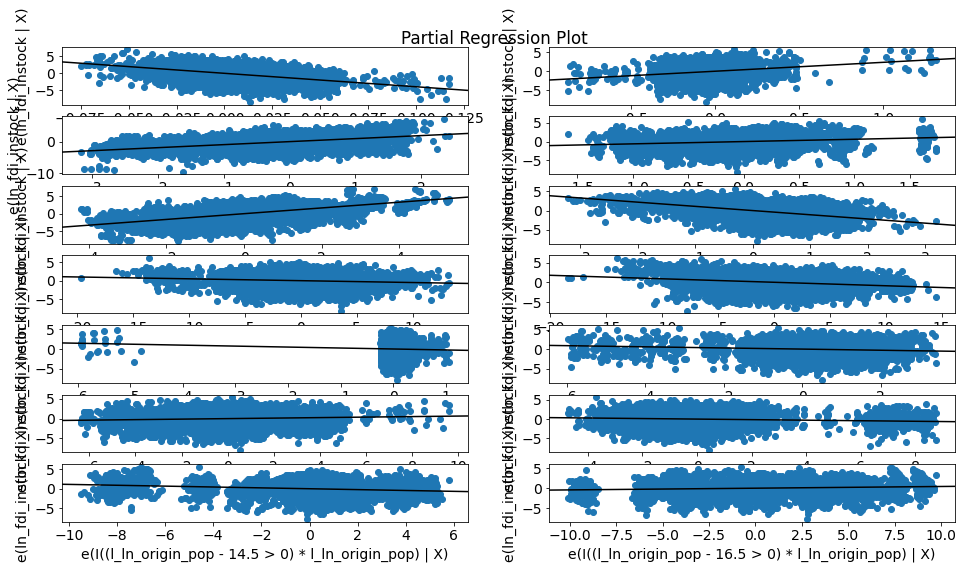

In [ ]:
for x in [res_base, res_aug]:
  fig = sm.graphics.plot_partregress_grid(x)